In [23]:
"""
SDWFS_SurfDen-Color_trend.ipynb
Author: Benjamin Floyd

Generates the plot of how the total AGN surface density changes with selection color threshold.
"""

import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.units import Quantity

%matplotlib inline

In [24]:
# Read in the SDWFS AGN catalog
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN_purity.fits')

# List all mask files
mask_files = [cutout['MASK_NAME'][0] for cutout in sdwfs_agn.group_by('CUTOUT_ID').groups]

# Get the color thresholds used in catalog creation
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f:
    color_threshold_data = json.load(f)
    color_thresholds = color_threshold_data['purity_90_colors']

In [25]:
# Read in each mask file and calculate the allowable area
areas = []
for mask_file in mask_files:
    mask_img, mask_hdr = fits.getdata(mask_file, header=True)
    mask_wcs = WCS(mask_hdr)

    # Get the area of a pixel in angular units
    pixel_area = mask_wcs.proj_plane_pixel_area()

    # Find the total area of the image by adding all pixels and multiplying by the pixel area
    mask_area = np.count_nonzero(mask_img) * pixel_area
    areas.append(mask_area)

# Compute total area in sample
total_area = Quantity(areas).sum()

In [26]:
# For each color selection threshold, add all objects applying the appropriate corrections
completeness_correction = sdwfs_agn['COMPLETENESS_CORRECTION']
selection_membership_columns = [colname for colname in sdwfs_agn.colnames if 'SELECTION_MEMBERSHIP' in colname]

numbers_agn = [np.sum(completeness_correction * sdwfs_agn[selection_membership_column])
               for selection_membership_column in selection_membership_columns]

In [27]:
# Create surface density array
agn_surf_den = numbers_agn / total_area

# Also generate Poisson errors for the surface densities
agn_surf_den_err = np.sqrt(agn_surf_den) / total_area

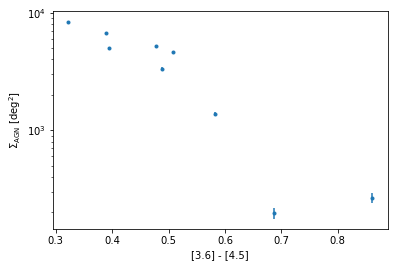

In [37]:
# Create plot
fig, ax = plt.subplots()
ax.errorbar(color_thresholds[:-1], agn_surf_den.value, yerr=agn_surf_den_err.value, fmt='.')
ax.set(xlabel='[3.6] - [4.5]', ylabel=r'$\Sigma_{\mathrm{AGN}}$ [deg$^2$]', yscale='log')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/Plots/AGN_SurfDen-Color_threshold.pdf')
plt.show()